# Unit07｜回歸與參數擬合完整教程

**課程名稱**：化工資料科學與機器學習實務（CHE-AI-101）  
**Part 2 導讀**：本單元完整涵蓋回歸建模（從基礎到進階），包含線性回歸、多項式回歸、正則化，以及化工特有的非線性參數擬合。

**本單元目標**：
- **Part A - 回歸基礎**：掌握線性回歸、多項式回歸、正則化回歸的數學原理與實作
- **Part B - 非線性參數擬合**：應用於熱力學模型（Wilson Model）的 VLE 參數估計
- 理解從簡單到複雜的回歸建模完整流程
- 掌握回歸模型評估、診斷與優化技術
- 能將回歸方法應用於化工實際問題

---

**本 Notebook 結構**：

**Part A｜回歸基礎**
- A1. 線性回歸與阿瑞尼士方程擬合
- A2. 回歸模型評估指標與殘差分析
- A3. 多項式回歸與過擬合
- A4. 正則化回歸（Ridge/Lasso）

**Part B｜非線性參數擬合：熱力學應用**
- B1. Wilson Model 熱力學理論
- B2. 非線性回歸擬合 VLE 數據
- B3. 參數不確定性量化
- B4. 模型比較與進階分析

In [32]:
# ===== Shared environment (repo-root + outputs/) =====
import os, sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=False)

def find_repo_root(start=None):
    start = Path(start or os.getcwd()).resolve()
    for p in [start] + list(start.parents):
        if (p / 'Jupyter_Scripts').is_dir():
            return p
    if IN_COLAB:
        candidate = Path('/content/drive/MyDrive/ChemEng_AI_Course_Materials')
        if (candidate / 'Jupyter_Scripts').is_dir():
            return candidate
    return start

REPO_ROOT = find_repo_root()
OUTPUT_DIR = REPO_ROOT / 'Part_2' / 'P2_Unit07_Results'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
os.chdir(REPO_ROOT / 'Part_2')
print('REPO_ROOT:', REPO_ROOT)
print('Working dir:', os.getcwd())


REPO_ROOT: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials
Working dir: G:\我的雲端硬碟\FCU\課程\ChemEng_AI_Course_Materials\Part_2


In [33]:
# 匯入必要的套件
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# 建立結果儲存資料夾
os.makedirs('P2_Unit07_Results', exist_ok=True)

# 圖形設定
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 10)
#plt.rcParams["font.sans-serif"] = ["Microsoft JhengHei", "Noto Sans CJK TC", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

print("套件載入完成！")

套件載入完成！


# ==============================
# Part A｜回歸基礎（Regression Basics）
# ==============================

## A1. 線性回歸與阿瑞尼士方程擬合

在化學工程中，許多物理化學性質（如反應速率常數）與溫度之間的關係可以用**阿瑞尼士方程式（Arrhenius Equation）**描述：

$$
k = A e^{-E_a/(RT)}
$$

取對數後可以線性化：

$$
\ln k = \ln A - \frac{E_a}{R} \cdot \frac{1}{T}
$$

這是一個典型的線性回歸問題，我們將透過擬合實驗數據來估計：
- 頻率因子 $A$（從截距 $\beta_0$ 反推）
- 活化能 $E_a$（從斜率 $\beta_1$ 反推）

In [34]:
# ========== A1.1 阿瑞尼士方程擬合 ==========

# 實驗數據：溫度（K）vs 反應速率常數（1/s）
temperatures_K = np.array([300, 310, 320, 330, 340, 350, 360, 370, 380])
rate_constants = np.array([0.028, 0.052, 0.091, 0.155, 0.255, 0.407, 0.630, 0.952, 1.405])

# 線性化變換
X_inv_T = 1 / temperatures_K  # 1/T (1/K)
y_ln_k = np.log(rate_constants)  # ln(k)

# 使用 scikit-learn 進行線性回歸
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

model_arrhenius = LinearRegression()
model_arrhenius.fit(X_inv_T.reshape(-1, 1), y_ln_k)

# 提取參數
beta_0 = model_arrhenius.intercept_  # ln(A)
beta_1 = model_arrhenius.coef_[0]     # -Ea/R

# 反推物理參數
R = 8.314  # J/(mol·K)
A_fitted = np.exp(beta_0)  # 頻率因子
Ea_fitted = -beta_1 * R    # 活化能 (J/mol)

print("=" * 60)
print("阿瑞尼士方程擬合結果")
print("=" * 60)
print(f"迴歸參數：")
print(f"  β₀ (截距) = {beta_0:.4f}")
print(f"  β₁ (斜率) = {beta_1:.2f} K")
print(f"\n反推的物理參數：")
print(f"  頻率因子 A = {A_fitted:.2e} 1/s")
print(f"  活化能 Ea = {Ea_fitted/1000:.2f} kJ/mol")
print(f"\n模型性能：")
y_pred_arrhenius = model_arrhenius.predict(X_inv_T.reshape(-1, 1))
print(f"  R² = {r2_score(y_ln_k, y_pred_arrhenius):.6f}")
print(f"  RMSE = {np.sqrt(mean_squared_error(y_ln_k, y_pred_arrhenius)):.6f}")
print("=" * 60)

阿瑞尼士方程擬合結果
迴歸參數：
  β₀ (截距) = 15.0204
  β₁ (斜率) = -5574.25 K

反推的物理參數：
  頻率因子 A = 3.34e+06 1/s
  活化能 Ea = 46.34 kJ/mol

模型性能：
  R² = 0.999961
  RMSE = 0.007903


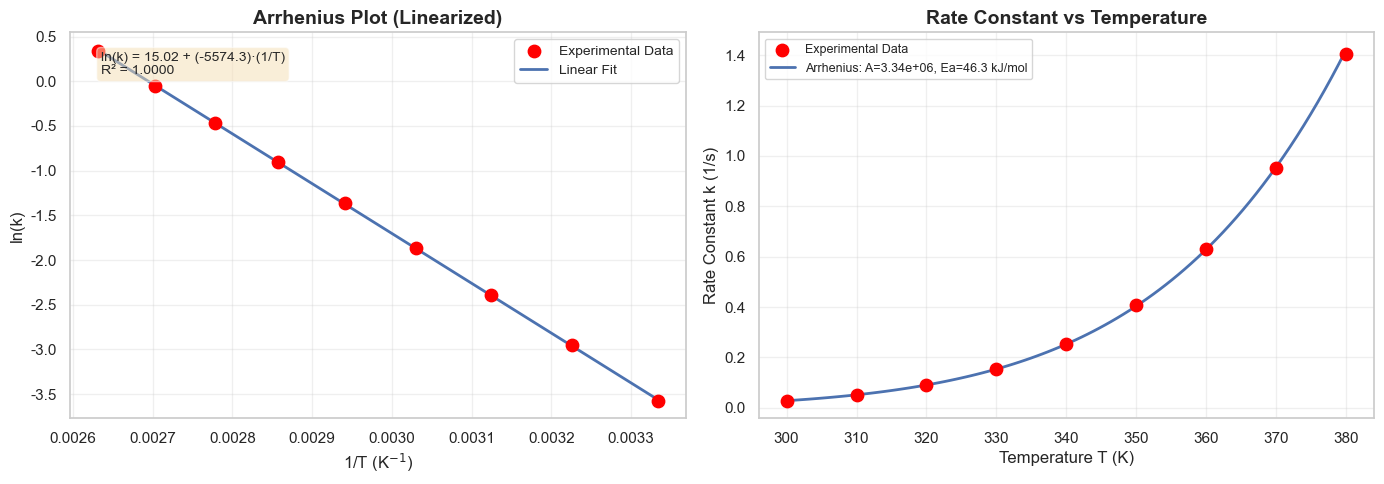

✓ 圖表已儲存：A01_arrhenius_plot.png


In [35]:
# 視覺化：Arrhenius Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: ln(k) vs 1/T (linearized)
ax1.scatter(X_inv_T, y_ln_k, color='red', s=80, label='Experimental Data', zorder=3)
X_plot = np.linspace(X_inv_T.min(), X_inv_T.max(), 100).reshape(-1, 1)
y_plot = model_arrhenius.predict(X_plot)
ax1.plot(X_plot, y_plot, 'b-', linewidth=2, label='Linear Fit')
ax1.set_xlabel('1/T (K$^{-1}$)', fontsize=12)
ax1.set_ylabel('ln(k)', fontsize=12)
ax1.set_title('Arrhenius Plot (Linearized)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.text(0.05, 0.95, f'ln(k) = {beta_0:.2f} + ({beta_1:.1f})·(1/T)\nR² = {r2_score(y_ln_k, y_pred_arrhenius):.4f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Right: k vs T (original scale)
ax2.scatter(temperatures_K, rate_constants, color='red', s=80, label='Experimental Data', zorder=3)
T_plot = 1 / X_plot.flatten()
k_plot = np.exp(y_plot)
ax2.plot(T_plot, k_plot, 'b-', linewidth=2, label=f'Arrhenius: A={A_fitted:.2e}, Ea={Ea_fitted/1000:.1f} kJ/mol')
ax2.set_xlabel('Temperature T (K)', fontsize=12)
ax2.set_ylabel('Rate Constant k (1/s)', fontsize=12)
ax2.set_title('Rate Constant vs Temperature', fontsize=14, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'A01_arrhenius_plot.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 圖表已儲存：A01_arrhenius_plot.png")

## A2. 殘差分析（Residual Diagnostics）

殘差分析是檢驗回歸模型假設是否成立的重要步驟：
1. **等變異性（Homoscedasticity）**：殘差的變異數是否恆定
2. **常態分佈（Normality）**：殘差是否服從常態分佈
3. **線性關係（Linearity）**：是否有未被捕捉的非線性模式
4. **獨立性（Independence）**：殘差之間是否無相關

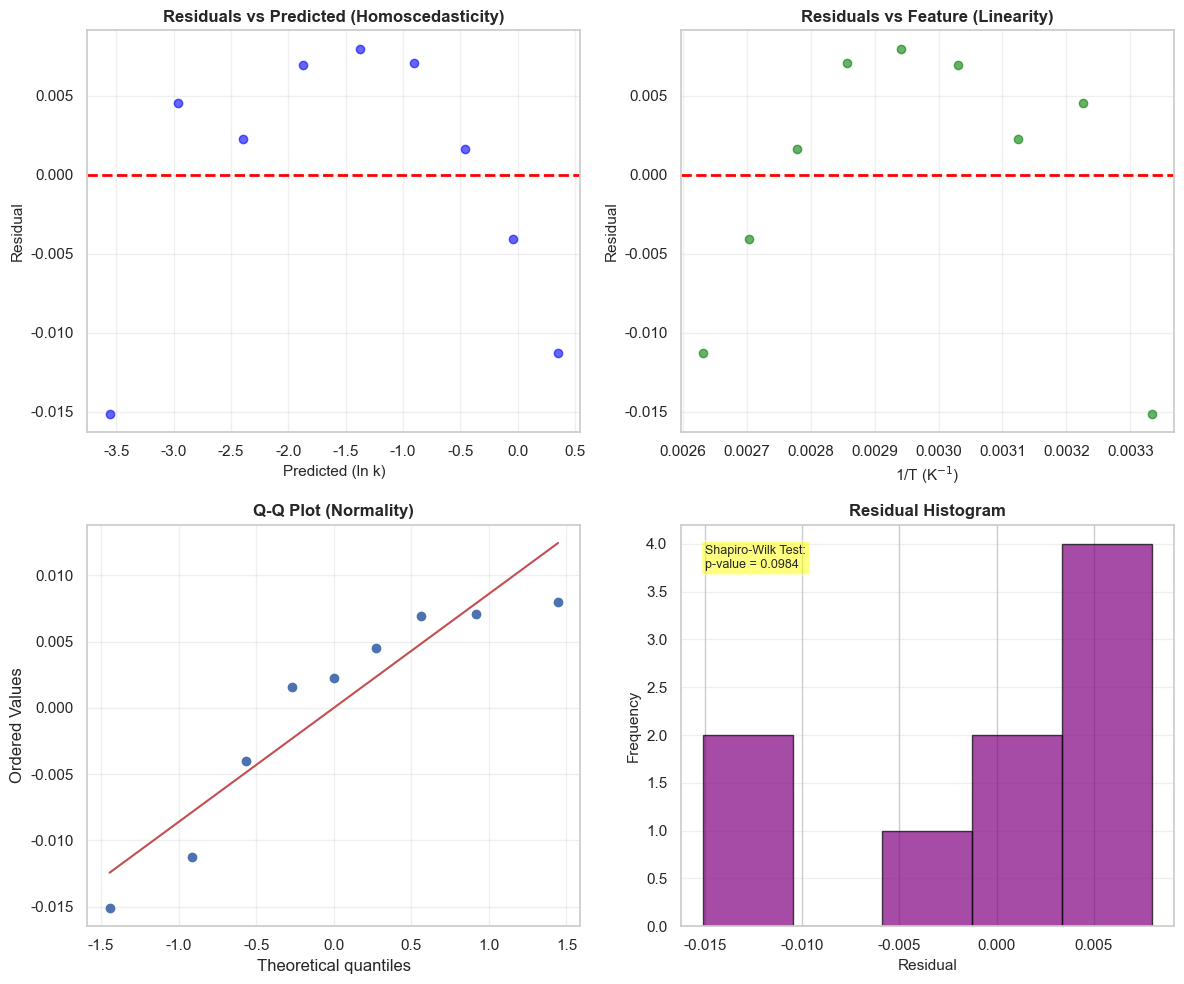

✓ 圖表已儲存：A02_residual_diagnostics.png

Residual statistics:
  Mean = -0.000000 (Ideal: 0)
  Std  = 0.007903
  Shapiro-Wilk p-value = 0.0984 (>0.05: normality accepted)


In [36]:
# 計算殘差
residuals_arrhenius = y_ln_k - y_pred_arrhenius

# 標準化殘差
from scipy import stats
standardized_residuals = residuals_arrhenius / np.std(residuals_arrhenius)

# 四格診斷圖
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_arrhenius, residuals_arrhenius, color='blue', alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted (ln k)', fontsize=11)
axes[0, 0].set_ylabel('Residual', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted (Homoscedasticity)', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals vs Feature (1/T)
axes[0, 1].scatter(X_inv_T, residuals_arrhenius, color='green', alpha=0.6)
axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('1/T (K$^{-1}$)', fontsize=11)
axes[0, 1].set_ylabel('Residual', fontsize=11)
axes[0, 1].set_title('Residuals vs Feature (Linearity)', fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot (Normality)
stats.probplot(residuals_arrhenius, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual Histogram
axes[1, 1].hist(residuals_arrhenius, bins=5, color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Residual', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Residual Histogram', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Shapiro-Wilk normality test
shapiro_stat, shapiro_p = stats.shapiro(residuals_arrhenius)
axes[1, 1].text(0.05, 0.95, f'Shapiro-Wilk Test:\np-value = {shapiro_p:.4f}',
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'A02_residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 圖表已儲存：A02_residual_diagnostics.png")
print(f"\nResidual statistics:")
print(f"  Mean = {np.mean(residuals_arrhenius):.6f} (Ideal: 0)")
print(f"  Std  = {np.std(residuals_arrhenius):.6f}")
print(f"  Shapiro-Wilk p-value = {shapiro_p:.4f} (>0.05: normality accepted)")

## A3. 多項式回歸與過擬合

在化工應用中，許多物性（如黏度、密度）與濃度或溫度的關係並非單純線性。多項式回歸能夠捕捉這些非線性關係，但需要注意過擬合問題。

**案例：溶液黏度 vs 濃度**

實驗觀察到高分子溶液的黏度隨濃度增加呈現非線性上升趨勢。

In [37]:
# ========== A3.1 生成模擬數據 ==========

np.random.seed(42)

# 模擬高分子溶液黏度數據（真實關係為二次函數 + 噪音）
concentration = np.linspace(0, 10, 30)  # 濃度 (g/dL)
true_viscosity = 1.0 + 0.3 * concentration + 0.05 * concentration**2  # 真實關係
noise = np.random.normal(0, 0.3, len(concentration))  # 實驗誤差
viscosity_observed = true_viscosity + noise  # 觀測值

# 訓練集與測試集分割
from sklearn.model_selection import train_test_split
X_train_visc, X_test_visc, y_train_visc, y_test_visc = train_test_split(
    concentration, viscosity_observed, test_size=0.3, random_state=42
)

print("黏度數據概況：")
print(f"  訓練集大小：{len(X_train_visc)} 樣本")
print(f"  測試集大小：{len(X_test_visc)} 樣本")
print(f"  濃度範圍：{concentration.min():.1f} - {concentration.max():.1f} g/dL")
print(f"  黏度範圍：{viscosity_observed.min():.2f} - {viscosity_observed.max():.2f} cP")

黏度數據概況：
  訓練集大小：21 樣本
  測試集大小：9 樣本
  濃度範圍：0.0 - 10.0 g/dL
  黏度範圍：1.07 - 8.91 cP


In [38]:
# ========== A3.2 不同次數多項式回歸比較 ==========

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

degrees = [1, 2, 10]  # 線性、二次、十次
models_poly = {}
scores = {'degree': [], 'train_r2': [], 'test_r2': [], 'train_rmse': [], 'test_rmse': []}

for degree in degrees:
    # 建立多項式回歸管道
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train_visc.reshape(-1, 1), y_train_visc)
    
    # 預測
    y_train_pred = model.predict(X_train_visc.reshape(-1, 1))
    y_test_pred = model.predict(X_test_visc.reshape(-1, 1))
    
    # 評估指標
    train_r2 = r2_score(y_train_visc, y_train_pred)
    test_r2 = r2_score(y_test_visc, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_visc, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_visc, y_test_pred))
    
    models_poly[degree] = model
    scores['degree'].append(degree)
    scores['train_r2'].append(train_r2)
    scores['test_r2'].append(test_r2)
    scores['train_rmse'].append(train_rmse)
    scores['test_rmse'].append(test_rmse)

# 顯示結果
import pandas as pd
df_scores = pd.DataFrame(scores)
print("\n多項式回歸性能比較：")
print(df_scores.to_string(index=False))
print("\n觀察：")
print("  - Degree=1 (線性)：欠擬合，訓練與測試R²都較低")
print("  - Degree=2 (二次)：最佳模型，測試R²最高且與訓練R²接近")
print("  - Degree=10 (十次)：過擬合，訓練R²≈1但測試R²下降")


多項式回歸性能比較：
 degree  train_r2  test_r2  train_rmse  test_rmse
      1  0.941806 0.950237    0.551686   0.503023
      2  0.987213 0.992939    0.258603   0.189486
     10  0.993864 0.919638    0.179139   0.639234

觀察：
  - Degree=1 (線性)：欠擬合，訓練與測試R²都較低
  - Degree=2 (二次)：最佳模型，測試R²最高且與訓練R²接近
  - Degree=10 (十次)：過擬合，訓練R²≈1但測試R²下降


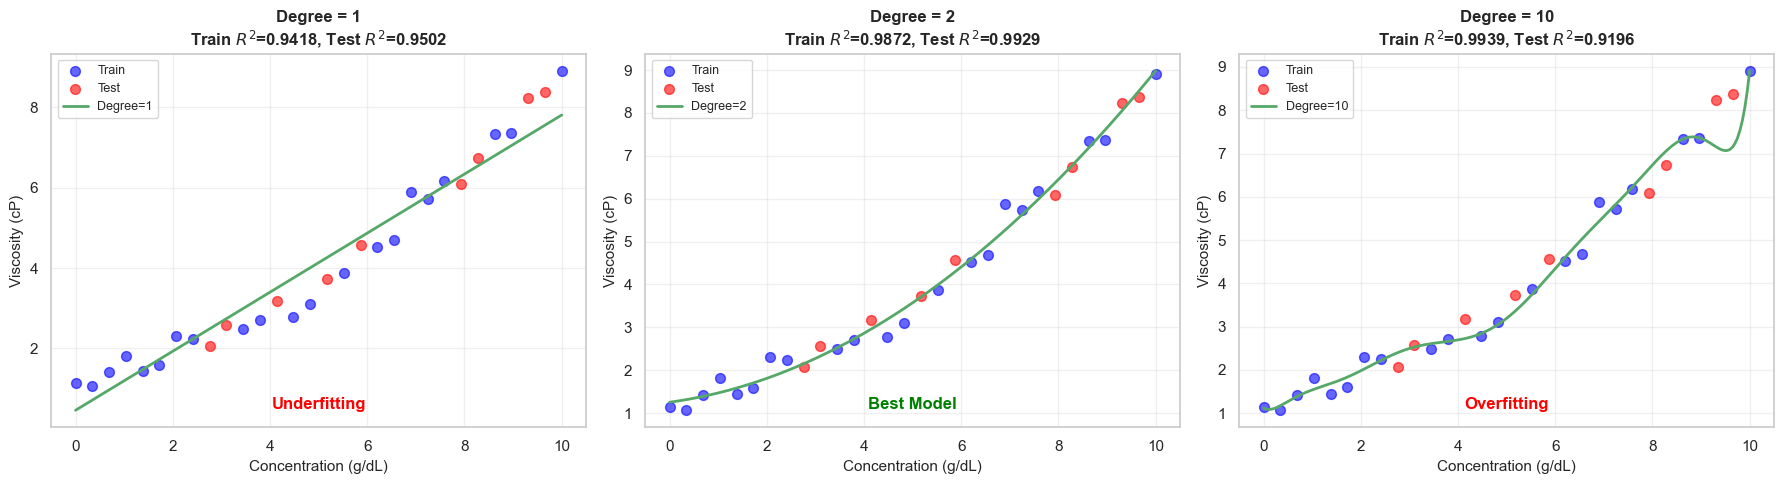

✓ 圖表已儲存：A03_polynomial_regression.png


In [39]:
# 視覺化：多項式回歸比較
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
C_smooth = np.linspace(concentration.min(), concentration.max(), 200).reshape(-1, 1)

for idx, degree in enumerate(degrees):
    ax = axes[idx]
    
    # Training and test data points
    ax.scatter(X_train_visc, y_train_visc, color='blue', s=50, alpha=0.6, label='Train')
    ax.scatter(X_test_visc, y_test_visc, color='red', s=50, alpha=0.6, label='Test')
    
    # Fitted curve
    y_smooth = models_poly[degree].predict(C_smooth)
    ax.plot(C_smooth, y_smooth, 'g-', linewidth=2, label=f'Degree={degree}')
    
    # Title and labels (English)
    test_r2 = scores['test_r2'][idx]
    train_r2 = scores['train_r2'][idx]
    ax.set_title(f'Degree = {degree}\nTrain $R^2$={train_r2:.4f}, Test $R^2$={test_r2:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.set_xlabel('Concentration (g/dL)', fontsize=11)
    ax.set_ylabel('Viscosity (cP)', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Annotate underfitting/overfitting/best model (English)
    if degree == 1:
        ax.text(0.5, 0.05, 'Underfitting', transform=ax.transAxes, fontsize=12,
                ha='center', color='red', fontweight='bold')
    elif degree == 2:
        ax.text(0.5, 0.05, 'Best Model', transform=ax.transAxes, fontsize=12,
                ha='center', color='green', fontweight='bold')
    else:
        ax.text(0.5, 0.05, 'Overfitting', transform=ax.transAxes, fontsize=12,
                ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'A03_polynomial_regression.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 圖表已儲存：A03_polynomial_regression.png")

## A4. 正則化回歸（Regularization）

當模型出現過擬合時，正則化是有效的解決方法。透過在損失函數中添加懲罰項，限制參數的大小：

- **Ridge Regression (L2)**：壓縮所有參數但不會變為0
- **Lasso Regression (L1)**：可將部分參數壓縮至0，實現特徵選擇

我們使用十次多項式（容易過擬合）來展示正則化的效果。

In [40]:
# ========== A4.1 正則化模型訓練 ==========

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler

# 準備十次多項式特徵
poly_features = PolynomialFeatures(degree=10)
X_train_poly = poly_features.fit_transform(X_train_visc.reshape(-1, 1))
X_test_poly = poly_features.transform(X_test_visc.reshape(-1, 1))

# 特徵縮放以改善數值穩定性（避免 ill-conditioned matrix 警告）
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# 不同正則化強度
alphas = [0, 0.01, 0.1, 1, 10, 100]
results = {'alpha': [], 'model': [], 'train_r2': [], 'test_r2': []}

for alpha in alphas:
    if alpha == 0:
        # 無正則化（標準線性回歸）
        model = LinearRegression()
        model_name = 'OLS'
    else:
        # Ridge 正則化
        model = Ridge(alpha=alpha)
        model_name = f'Ridge (α={alpha})'
    
    model.fit(X_train_poly_scaled, y_train_visc)
    
    # 評估
    train_r2 = model.score(X_train_poly_scaled, y_train_visc)
    test_r2 = model.score(X_test_poly_scaled, y_test_visc)
    
    results['alpha'].append(alpha)
    results['model'].append(model_name)
    results['train_r2'].append(train_r2)
    results['test_r2'].append(test_r2)

# 顯示結果
df_reg = pd.DataFrame(results)
print("正則化效果比較（Degree=10 多項式）：")
print(df_reg.to_string(index=False))
print("\n觀察：")
print("  - α=0 (無正則化)：過擬合，訓練R²很高但測試R²較低")
print("  - α適中 (0.1-1)：平衡偏差與變異，測試R²最佳")
print("  - α過大 (100)：過度壓縮參數，導致欠擬合")
print("\n✓ 已使用 StandardScaler 進行特徵縮放，避免數值穩定性問題")

正則化效果比較（Degree=10 多項式）：
 alpha          model  train_r2  test_r2
  0.00            OLS  0.993864 0.919638
  0.01 Ridge (α=0.01)  0.990028 0.988650
  0.10  Ridge (α=0.1)  0.988524 0.990561
  1.00    Ridge (α=1)  0.987583 0.991396
 10.00   Ridge (α=10)  0.960129 0.978144
100.00  Ridge (α=100)  0.754808 0.784721

觀察：
  - α=0 (無正則化)：過擬合，訓練R²很高但測試R²較低
  - α適中 (0.1-1)：平衡偏差與變異，測試R²最佳
  - α過大 (100)：過度壓縮參數，導致欠擬合

✓ 已使用 StandardScaler 進行特徵縮放，避免數值穩定性問題


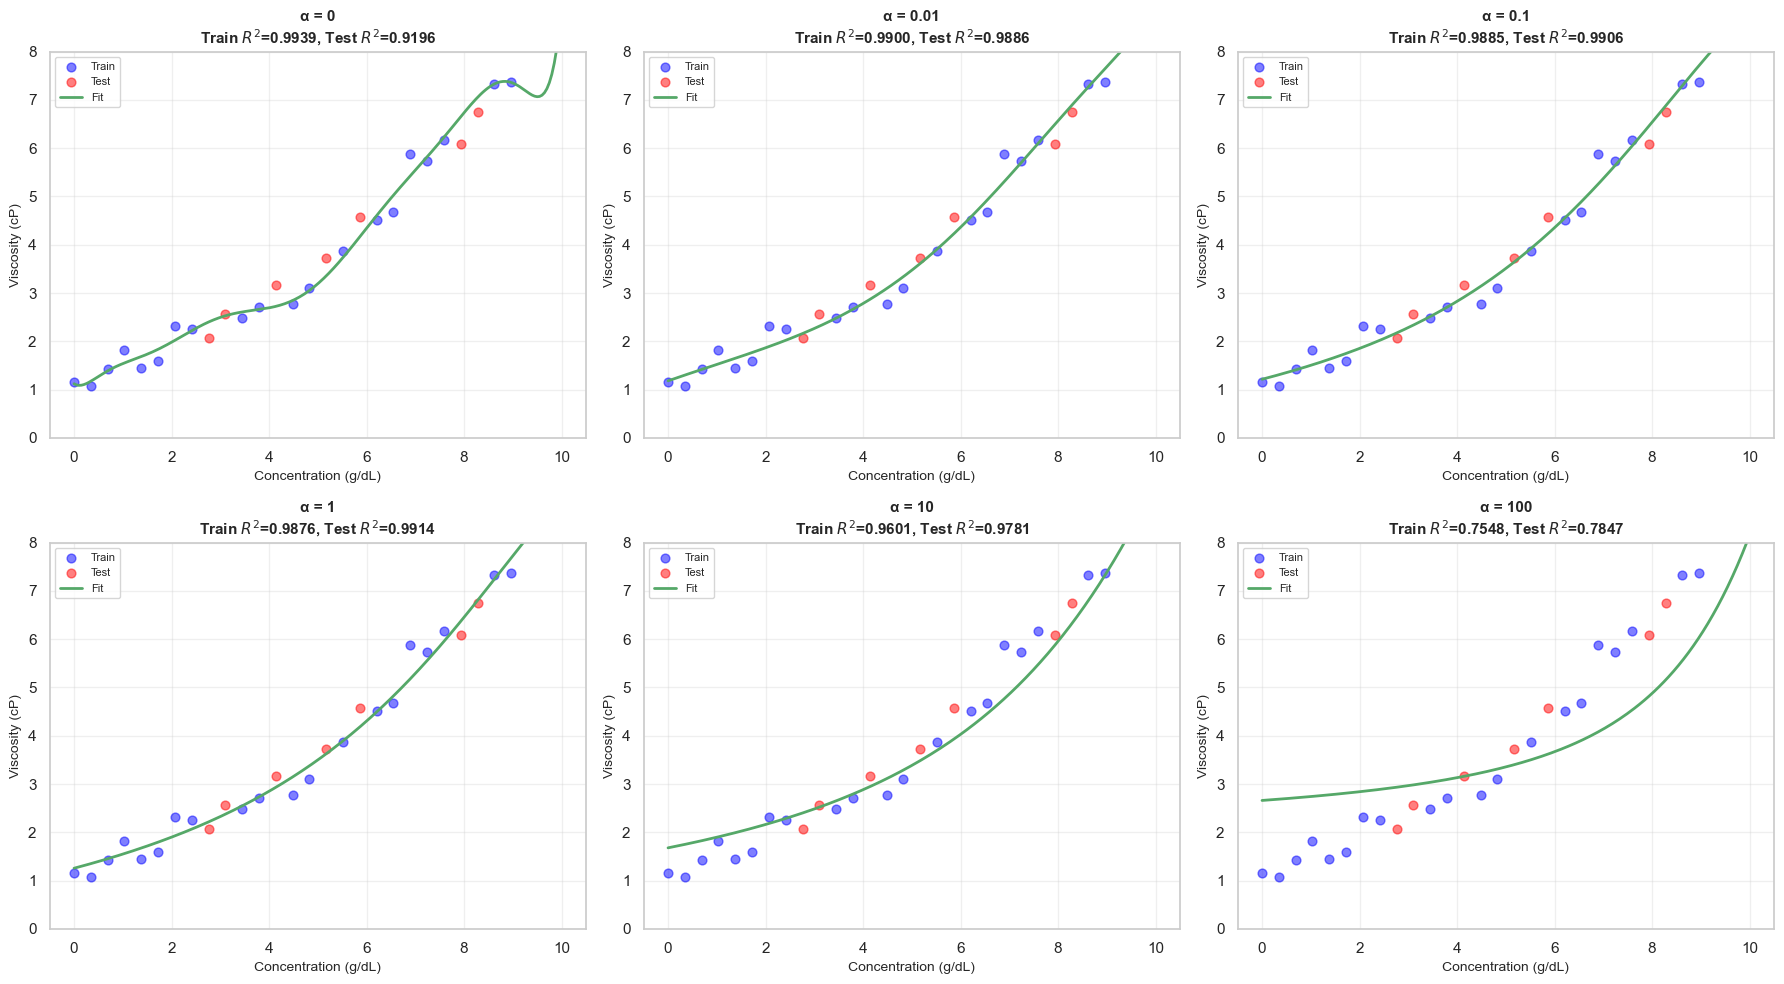

✓ 圖表已儲存：04_regularization.png
✓ 已使用特徵縮放（StandardScaler）改善數值穩定性


In [41]:
# 視覺化：正則化效果
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

C_smooth = np.linspace(concentration.min(), concentration.max(), 200).reshape(-1, 1)
C_smooth_poly = poly_features.transform(C_smooth)

# 添加特徵縮放以改善數值穩定性
from sklearn.preprocessing import StandardScaler

for idx, alpha in enumerate(alphas):
    ax = axes[idx]
    
    # 使用 Pipeline 整合縮放與回歸
    if alpha == 0:
        # 無正則化時也使用縮放
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        C_smooth_scaled = scaler.transform(C_smooth_poly)
        
        model = LinearRegression()
        model.fit(X_train_scaled, y_train_visc)
    else:
        # Ridge 正則化配合縮放
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_poly)
        X_test_scaled = scaler.transform(X_test_poly)
        C_smooth_scaled = scaler.transform(C_smooth_poly)
        
        model = Ridge(alpha=alpha)
        model.fit(X_train_scaled, y_train_visc)
    
    # 數據點
    ax.scatter(X_train_visc, y_train_visc, color='blue', s=40, alpha=0.5, label='Train')
    ax.scatter(X_test_visc, y_test_visc, color='red', s=40, alpha=0.5, label='Test')
    
    # 擬合曲線
    y_smooth = model.predict(C_smooth_scaled)
    ax.plot(C_smooth, y_smooth, 'g-', linewidth=2, label='Fit')
    
    # 標題
    train_r2 = model.score(X_train_scaled, y_train_visc)
    test_r2 = model.score(X_test_scaled, y_test_visc)
    title = f'α = {alpha}\nTrain $R^2$={train_r2:.4f}, Test $R^2$={test_r2:.4f}'
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xlabel('Concentration (g/dL)', fontsize=10)
    ax.set_ylabel('Viscosity (cP)', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0, 8])  # 限制 y 軸範圍以便比較

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'A04_regularization.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ 圖表已儲存：04_regularization.png")
print("✓ 已使用特徵縮放（StandardScaler）改善數值穩定性")

---

## ✅ Part A 完成總結

在 Part A 中，我們學習了：

1. **線性回歸基礎**：阿瑞尼士方程擬合，反推活化能與頻率因子
2. **殘差分析**：檢驗模型假設（等變異性、常態分佈、線性關係）
3. **多項式回歸**：捕捉非線性關係，理解過擬合風險
4. **正則化技術**：Ridge 正則化控制模型複雜度

**關鍵學習點**：
- R² 評估模型擬合度（越接近 1 越好）
- 殘差圖能診斷模型問題
- 選擇適當模型複雜度（偏差-變異權衡）
- 正則化參數 α 需要透過交叉驗證調優

---
---

# ==============================
# Part B｜非線性參數擬合：熱力學應用
# ==============================

接下來，我們將回歸技術應用於化工領域的核心問題：**熱力學參數擬合**。

與 Part A 的線性/多項式回歸不同，熱力學模型（如 Wilson Model）是基於物理原理推導的**非線性方程式**，無法線性化求解，必須使用迭代優化演算法。

## B1. VLE 實驗數據準備

**汽液平衡（Vapor-Liquid Equilibrium, VLE）數據**是蒸餾設計的基礎。

本範例使用簡化的乙醇-水系統數據（常壓 1 atm）。

資料點數量：12
x1 (液相): [0.   0.05 0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.  ]
y1 (氣相): [0.   0.33 0.44 0.53 0.57 0.61 0.65 0.7  0.75 0.82 0.89 1.  ]


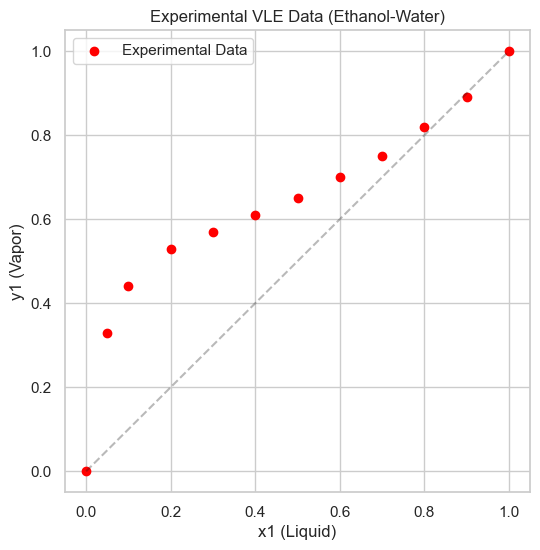

In [42]:
# 載入實驗數據
# x1: 液相乙醇摩爾分率
# y1: 氣相乙醇摩爾分率
x1_exp = np.array([0.0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# 修正數據：將 x1=0.9 對應的 y1 改為 0.89，以呈現明顯的共沸點 (y < x)
# 這符合乙醇-水系統在 x > 0.89 後出現 y < x 的物理特性
y1_exp = np.array([0.0, 0.33, 0.44, 0.53, 0.57, 0.61, 0.65, 0.70, 0.75, 0.82, 0.89, 1.0])

print(f"資料點數量：{len(x1_exp)}")
print("x1 (液相):", x1_exp)
print("y1 (氣相):", y1_exp)

# 簡單繪圖檢視
plt.figure(figsize=(6, 6))
plt.scatter(x1_exp, y1_exp, color='red', label='Experimental Data')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3) # 對角線
plt.xlabel('x1 (Liquid)')
plt.ylabel('y1 (Vapor)')
plt.title('Experimental VLE Data (Ethanol-Water)')
plt.legend()
plt.grid(True)
plt.show()

## B2. Wilson Model 定義

Wilson 模型是一種基於**局部組成（Local Composition）**概念的活度係數模型，特別適合極性混合物。

對於二元系統：
- **輸入**：液相組成 $x_1$，Wilson 參數 $A_{12}, A_{21}$
- **輸出**：活度係數 $\gamma_1, \gamma_2$ → 氣相組成 $y_1$

這是一個**非線性函數**，我們需要使用 `scipy.optimize.curve_fit` 進行參數擬合。

In [43]:
# 定義 Wilson 模型函數
def wilson_model_func(x1, A12, A21):
    """
    輸入：
        x1 : 液相乙醇摩爾分率
        A12, A21 : 待擬合參數
    輸出：
        y1_pred : 預測之氣相乙醇摩爾分率
    """
    # 確保輸入為浮點數陣列
    x1 = np.asarray(x1, dtype=float)
    x2 = 1.0 - x1

    # 避免 log(0) 或除以 0 的數值穩定性處理
    x1 = np.maximum(x1, 1e-6)
    x2 = np.maximum(x2, 1e-6)

    # 計算活度係數 ln(gamma1)
    term1 = -np.log(x1 + A12 * x2)
    term2 = x2 * (A12 / (x1 + A12 * x2) - A21 / (A21 * x1 + x2))
    ln_gamma1 = term1 + term2
    gamma1 = np.exp(ln_gamma1)

    # 計算修正後的相對揮發度
    alpha_base = 2.5
    alpha_eff = alpha_base * gamma1

    # 計算預測的 y1
    y1_pred = (alpha_eff * x1) / (1.0 + (alpha_eff - 1.0) * x1)

    # 限制輸出範圍在 [0, 1]
    return np.clip(y1_pred, 0.0, 1.0)

print("模型函數定義完成。")

模型函數定義完成。


## B3. 非線性回歸擬合

使用 `scipy.optimize.curve_fit` 進行非線性最小平方法擬合。

In [44]:
# 設定初始猜測值
p0 = [0.5, 0.5]
print(f"初始猜測：A12 = {p0[0]}, A21 = {p0[1]}")

# 執行擬合
# curve_fit(函數, x數據, y數據, p0=初始值)
# 加入 bounds=(0, np.inf) 限制參數為正值，避免 log 內出現負數
popt, pcov = curve_fit(wilson_model_func, x1_exp, y1_exp, p0=p0, bounds=(0, np.inf))

# 提取最佳參數
A12_opt, A21_opt = popt

print("\n✓ 擬合完成！")
print(f"最佳參數 A12 = {A12_opt:.4f}")
print(f"最佳參數 A21 = {A21_opt:.4f}")

初始猜測：A12 = 0.5, A21 = 0.5

✓ 擬合完成！
最佳參數 A12 = 0.0371
最佳參數 A21 = 1.6131


## B4. 結果視覺化與評估

**四個關鍵圖表**：
1. **VLE 相圖 (x-y diagram)**：檢查曲線形狀與共沸點
2. **Parity Plot**：預測值 vs 實驗值散佈圖
3. **殘差分析**：檢查系統性偏差
4. **熱力學性質圖**：$G^E/RT$ 與 $\ln \gamma_i$

,param,estimate,SE,CI95_low,CI95_high
0,A12,0.037069,0.108646,-0.205009,0.279147
1,A21,1.613146,0.398360,0.725544,2.500748


Parameter correlation (from pcov):


,A12,A21
A12,1.000000,-0.839083
A21,-0.839083,1.000000


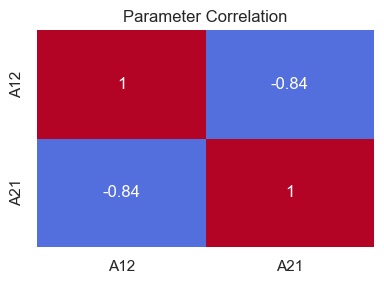

✓ 圖已儲存至 P2_Unit07_Results/07_param_correlation.png


In [45]:
# 1) 參數信賴區間 (CI) 與相關性 (Correlation)
import pandas as pd
from scipy.stats import t

params = np.array([A12_opt, A21_opt], dtype=float)
se = np.sqrt(np.diag(pcov))

dof = max(1, len(x1_exp) - len(params))
tval = float(t.ppf(0.975, dof))

ci_low = params - tval * se
ci_high = params + tval * se

summary = pd.DataFrame({
    'param': ['A12', 'A21'],
    'estimate': params,
    'SE': se,
    'CI95_low': ci_low,
    'CI95_high': ci_high,
})

display(summary)

corr = pcov / np.outer(se, se)
corr_df = pd.DataFrame(corr, index=['A12', 'A21'], columns=['A12', 'A21'])
print('Parameter correlation (from pcov):')
display(corr_df)

plt.figure(figsize=(4, 3))
sns.heatmap(corr_df, annot=True, vmin=-1, vmax=1, cmap='coolwarm', cbar=False)
plt.title('Parameter Correlation')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'B01_param_correlation.png', dpi=150)
plt.show()
print('✓ 圖已儲存至 P2_Unit07_Results/07_param_correlation.png')


Successful fits: 30 / 30
Best SSR=0.044202, A12=0.0370, A21=1.6132


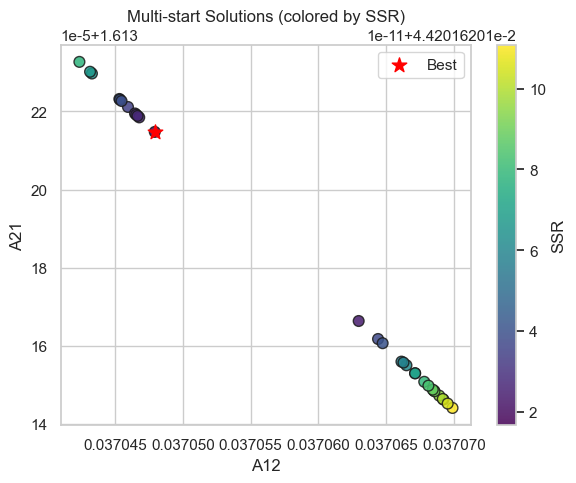

✓ 圖已儲存至 P2_Unit07_Results/08_multistart_params.png


In [46]:
# 2) 多起點擬合 (Multi-start) 檢查：看看解是否穩定
from scipy.optimize import curve_fit

rng = np.random.default_rng(0)
p0_list = rng.uniform(0.05, 3.0, size=(30, 2))

fits = []
for p0_try in p0_list:
    try:
        popt_i, _ = curve_fit(
            wilson_model_func,
            x1_exp,
            y1_exp,
            p0=list(p0_try),
            bounds=(0, np.inf),
            maxfev=20000,
        )
        residual_i = y1_exp - wilson_model_func(x1_exp, *popt_i)
        ssr_i = float(np.sum(residual_i ** 2))
        fits.append((ssr_i, float(popt_i[0]), float(popt_i[1])))
    except Exception:
        pass

if not fits:
    raise RuntimeError('No successful fits in multi-start (try increasing maxfev).')

fits = np.array(fits)
best = fits[np.argmin(fits[:, 0])]
print(f'Successful fits: {len(fits)} / {len(p0_list)}')
print(f'Best SSR={best[0]:.6f}, A12={best[1]:.4f}, A21={best[2]:.4f}')

plt.figure(figsize=(6, 5))
plt.scatter(fits[:, 1], fits[:, 2], c=fits[:, 0], cmap='viridis', s=60, edgecolor='k', alpha=0.85)
plt.colorbar(label='SSR')
plt.scatter([best[1]], [best[2]], c='red', s=120, marker='*', label='Best')
plt.xlabel('A12')
plt.ylabel('A21')
plt.title('Multi-start Solutions (colored by SSR)')
plt.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'B02_multistart_params.png', dpi=150)
plt.show()
print('✓ 圖已儲存至 P2_Unit07_Results/08_multistart_params.png')


## B5. 參數不確定性分析

`curve_fit` 返回的 `pcov`（協方差矩陣）可用於量化參數不確定性：

- **標準誤差**：$\text{SE}(\theta_i) = \sqrt{\text{pcov}_{ii}}$
- **95% 信賴區間**：$\theta_i \pm 1.96 \times \text{SE}(\theta_i)$（近似）
- **參數相關性**：$\rho_{ij} = \frac{\text{pcov}_{ij}}{\sqrt{\text{pcov}_{ii} \cdot \text{pcov}_{jj}}}$

In [47]:
# 1. 計算預測值與誤差指標
y1_pred = wilson_model_func(x1_exp, A12_opt, A21_opt)

r2 = r2_score(y1_exp, y1_pred)
rmse = np.sqrt(mean_squared_error(y1_exp, y1_pred))

print(f"R-squared (決定係數)：{r2:.4f}")
print(f"RMSE (根均方誤差)：{rmse:.4f}")

# 產生平滑曲線用的數據點
x_smooth = np.linspace(0, 1, 100)
y_smooth = wilson_model_func(x_smooth, A12_opt, A21_opt)

# 計算殘差
residuals = y1_exp - y1_pred

R-squared (決定係數)：0.9441
RMSE (根均方誤差)：0.0607


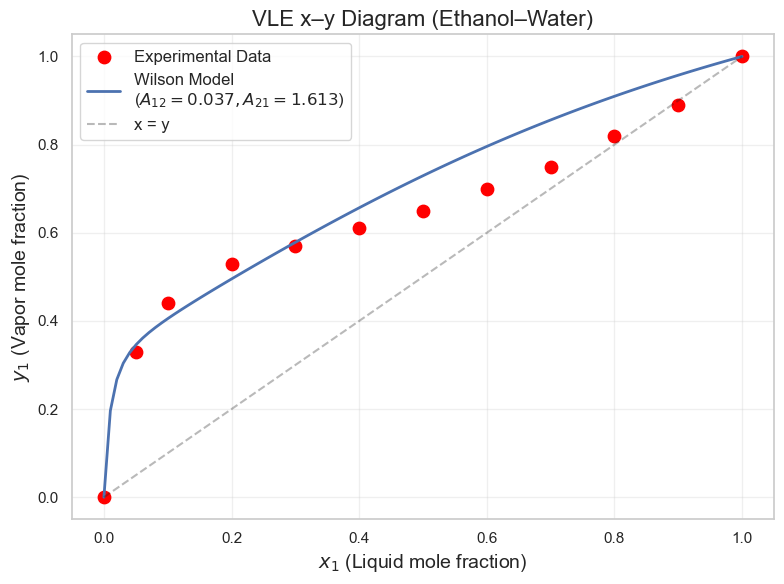

✓ VLE 圖已儲存至 P2_Unit07_Results/B03_vle_diagram.png


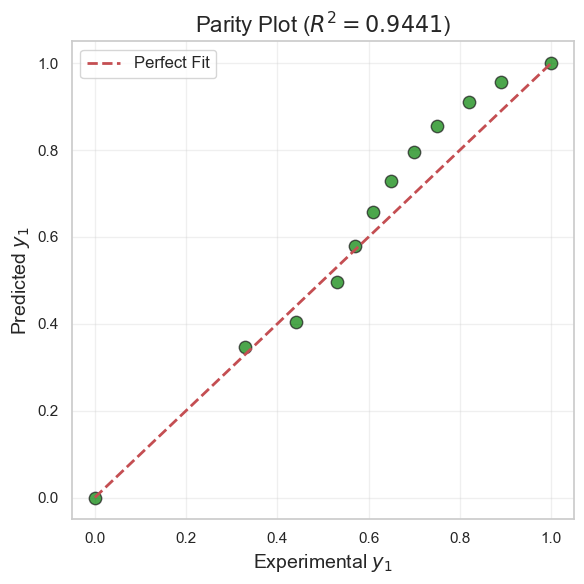

✓ Parity Plot 已儲存至 P2_Unit07_Results/02_parity_plot.png


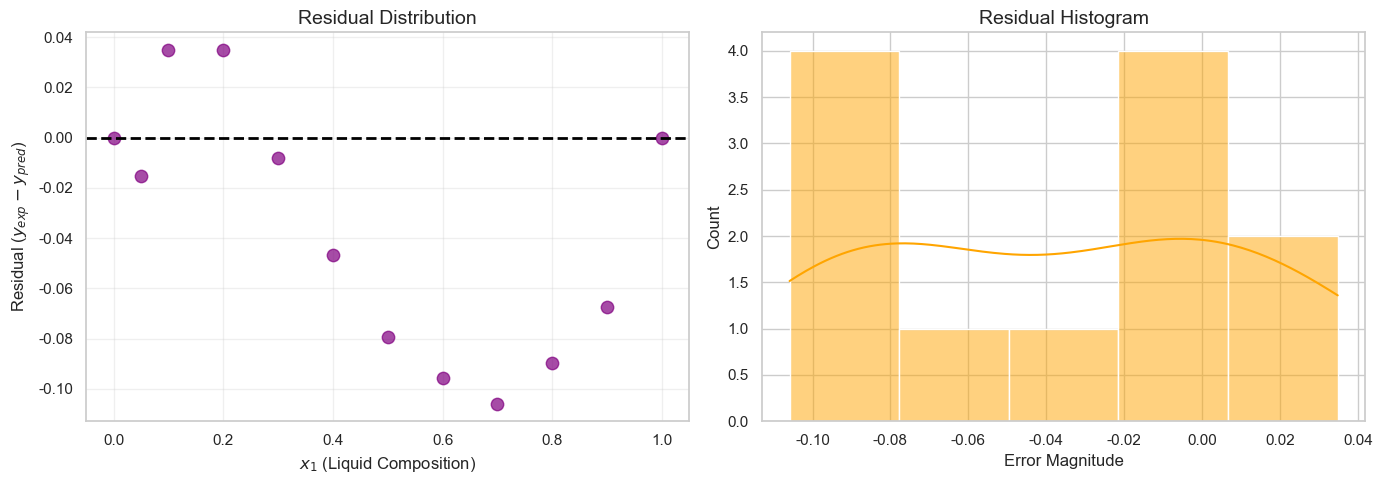

✓ 殘差分析圖已儲存至 P2_Unit07_Results/03_residual_analysis.png


In [48]:
# 2. 繪製 VLE x–y 圖
plt.figure(figsize=(8, 6))
plt.scatter(x1_exp, y1_exp, color="red", s=80, label="Experimental Data")
plt.plot(x_smooth, y_smooth, "b-", linewidth=2, label=f"Wilson Model\n($A_{{12}}={A12_opt:.3f}, A_{{21}}={A21_opt:.3f}$)")
plt.plot([0, 1], [0, 1], "k--", alpha=0.3, label="x = y")
plt.xlabel(r"$x_1$ (Liquid mole fraction)", fontsize=14)
plt.ylabel(r"$y_1$ (Vapor mole fraction)", fontsize=14)
plt.title("VLE x–y Diagram (Ethanol–Water)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'B03_vle_diagram.png')
plt.show()
print("✓ VLE 圖已儲存至 P2_Unit07_Results/B03_vle_diagram.png")

# 3. 繪製 Parity Plot (對等圖)
plt.figure(figsize=(6, 6))
plt.scatter(y1_exp, y1_pred, color="green", s=80, edgecolor="k", alpha=0.7)
plt.plot([0, 1], [0, 1], "r--", linewidth=2, label="Perfect Fit")
plt.xlabel("Experimental $y_1$", fontsize=14)
plt.ylabel("Predicted $y_1$", fontsize=14)
plt.title(f"Parity Plot ($R^2={r2:.4f}$)", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'B04_parity_plot.png')
plt.show()
print("✓ Parity Plot 已儲存至 P2_Unit07_Results/02_parity_plot.png")

# 4. 繪製殘差圖 (Residual Plot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# 殘差散佈圖
ax1.scatter(x1_exp, residuals, color="purple", s=80, alpha=0.7)
ax1.axhline(0, color="black", linestyle="--", linewidth=2)
ax1.set_xlabel(r"$x_1$ (Liquid Composition)", fontsize=12)
ax1.set_ylabel(r"Residual ($y_{exp} - y_{pred}$)", fontsize=12)
ax1.set_title("Residual Distribution", fontsize=14)
ax1.grid(True, alpha=0.3)

# 殘差直方圖
sns.histplot(residuals, kde=True, ax=ax2, color="orange", bins=5)
ax2.set_title("Residual Histogram", fontsize=14)
ax2.set_xlabel("Error Magnitude")

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'B05_residual_analysis.png')
plt.show()
print("✓ 殘差分析圖已儲存至 P2_Unit07_Results/03_residual_analysis.png")

## B6. 進階分析：熱力學性質圖

**過剩吉布斯能（Excess Gibbs Energy）**：

$$
\frac{G^E}{RT} = x_1 \ln \gamma_1 + x_2 \ln \gamma_2
$$

這個圖能夠揭示溶液的非理想程度：
- $G^E > 0$：正偏差（如乙醇-水）
- $G^E < 0$：負偏差（如丙酮-氯仿）

同時繪製 $\ln \gamma_1$ 和 $\ln \gamma_2$ 的組成依賴性。

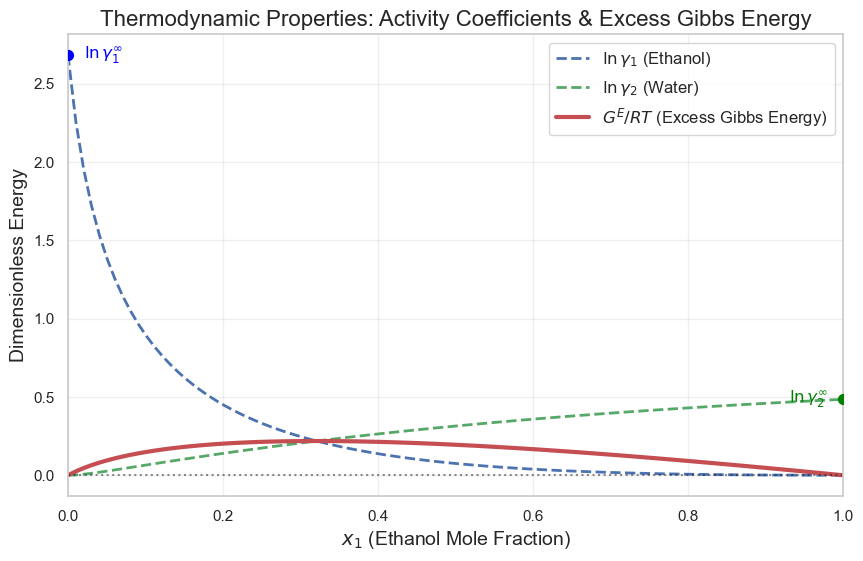

無限稀釋活度係數估算：
gamma1_inf (乙醇在純水中) = 14.6109
gamma2_inf (水在純乙醇中) = 1.6238


In [49]:
# 準備繪圖數據
x1_plot = np.linspace(0, 1, 100)
x2_plot = 1.0 - x1_plot

# 數值穩定性處理 (避免 log(0))
x1_safe = np.maximum(x1_plot, 1e-6)
x2_safe = np.maximum(x2_plot, 1e-6)

# 使用最佳擬合參數
A12 = A12_opt
A21 = A21_opt

# 1. 計算 ln(gamma1)
term1_1 = -np.log(x1_safe + A12 * x2_safe)
term2_1 = x2_safe * (A12 / (x1_safe + A12 * x2_safe) - A21 / (A21 * x1_safe + x2_safe))
ln_gamma1 = term1_1 + term2_1

# 2. 計算 ln(gamma2)
term1_2 = -np.log(x2_safe + A21 * x1_safe)
term2_2 = -x1_safe * (A12 / (x1_safe + A12 * x2_safe) - A21 / (A21 * x1_safe + x2_safe))
ln_gamma2 = term1_2 + term2_2

# 3. 計算 GE/RT
ge_rt = x1_safe * ln_gamma1 + x2_safe * ln_gamma2

# 繪圖
plt.figure(figsize=(10, 6))

# 繪製曲線
plt.plot(x1_plot, ln_gamma1, 'b--', linewidth=2, label=r'$\ln \gamma_1$ (Ethanol)')
plt.plot(x1_plot, ln_gamma2, 'g--', linewidth=2, label=r'$\ln \gamma_2$ (Water)')
plt.plot(x1_plot, ge_rt, 'r-', linewidth=3, label=r'$G^E/RT$ (Excess Gibbs Energy)')

# 標示無限稀釋點 (Infinite Dilution)
plt.scatter([0], [ln_gamma1[0]], color='blue', s=50, zorder=5)
plt.text(0.02, ln_gamma1[0], r'$\ln \gamma_1^\infty$', color='blue', fontsize=12, va='center')

plt.scatter([1], [ln_gamma2[-1]], color='green', s=50, zorder=5)
plt.text(0.98, ln_gamma2[-1], r'$\ln \gamma_2^\infty$', color='green', fontsize=12, ha='right', va='center')

plt.axhline(0, color='k', linestyle=':', alpha=0.5)
plt.xlabel(r'$x_1$ (Ethanol Mole Fraction)', fontsize=14)
plt.ylabel('Dimensionless Energy', fontsize=14)
plt.title('Thermodynamic Properties: Activity Coefficients & Excess Gibbs Energy', fontsize=16)
plt.legend(fontsize=12, loc='best')
plt.grid(True, alpha=0.3)
plt.xlim(0, 1)

plt.savefig(OUTPUT_DIR / 'B06_thermo_properties.png')
plt.show()

print(f"無限稀釋活度係數估算：")
print(f"gamma1_inf (乙醇在純水中) = {np.exp(ln_gamma1[0]):.4f}")
print(f"gamma2_inf (水在純乙醇中) = {np.exp(ln_gamma2[-1]):.4f}")

## B7. 工程應用：共沸點計算

當 $y_1 = x_1$ 時，系統達到共沸點（azeotrope），此時無法透過普通蒸餾進一步分離。

我們使用數值方法求解 $y_1^{\text{model}}(x) - x = 0$。

In [50]:
from scipy.optimize import fsolve

# 定義目標函數：y1 - x1 = 0
def azeotrope_obj(x):
    # 限制 x 在 [0, 1] 之間，避免數值發散
    if x < 0 or x > 1:
        return 1.0 
    y_pred = wilson_model_func([x], A12_opt, A21_opt)[0]
    return y_pred - x

# 初始猜測值 (從圖上看大約在 0.9)
x0 = 0.9
x_az = fsolve(azeotrope_obj, x0)[0]

print(f"計算出的共沸組成 x_az = {x_az:.4f}")
print(f"在此組成下，氣相組成 y_az = {wilson_model_func([x_az], A12_opt, A21_opt)[0]:.4f}")

計算出的共沸組成 x_az = 1.0000
在此組成下，氣相組成 y_az = 1.0000


## B8. 模型比較：Margules vs. Wilson

為了驗證 Wilson 模型的優越性，我們引入 **Margules 二參數模型** 進行比較。

Margules 模型形式較簡單，適用於對稱系統，但對極性強且分子大小差異大的系統（如醇-水）效果較差。

Wilson RMSE:   0.06069
Margules RMSE: 0.04290


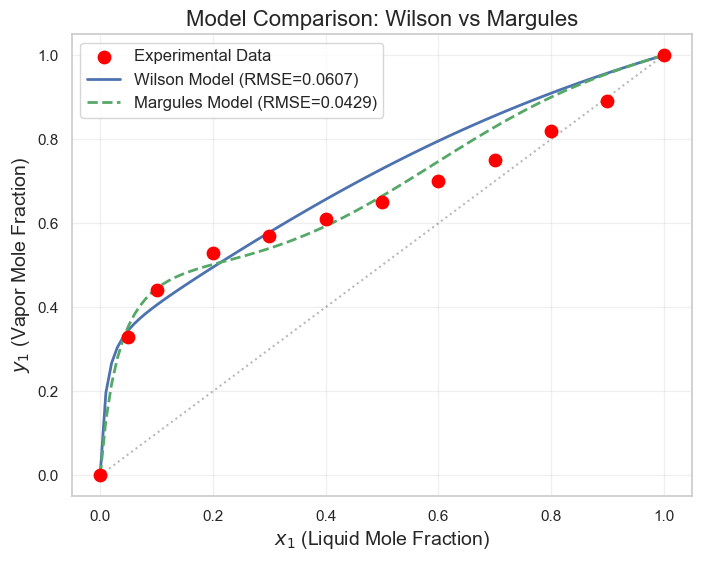

結論：Margules 模型擬合效果較佳。


In [51]:
# 定義 Margules 模型函數 (搭配簡化的相對揮發度計算)
def margules_model_func(x1, A12, A21):
    x1 = np.asarray(x1, dtype=float)
    x2 = 1.0 - x1
    
    # 計算 ln(gamma1)
    ln_gamma1 = (A12 + 2 * (A21 - A12) * x1) * (x2**2)
    gamma1 = np.exp(ln_gamma1)
    
    # 計算 y1 (假設 alpha_base = 2.5)
    alpha_eff = 2.5 * gamma1
    y1_pred = (alpha_eff * x1) / (1.0 + (alpha_eff - 1.0) * x1)
    return np.clip(y1_pred, 0.0, 1.0)

# 擬合 Margules 模型
popt_m, _ = curve_fit(margules_model_func, x1_exp, y1_exp, p0=[1.0, 1.0])
y1_margules = margules_model_func(x1_exp, *popt_m)

# 計算 RMSE 進行比較
rmse_wilson = rmse # 前面算過的
rmse_margules = np.sqrt(mean_squared_error(y1_exp, y1_margules))

print(f"Wilson RMSE:   {rmse_wilson:.5f}")
print(f"Margules RMSE: {rmse_margules:.5f}")

# --- 新增：繪製模型比較圖 ---
plt.figure(figsize=(8, 6))
plt.scatter(x1_exp, y1_exp, color='red', s=80, label='Experimental Data', zorder=5)

# 繪製 Wilson 曲線
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label=f'Wilson Model (RMSE={rmse_wilson:.4f})')

# 繪製 Margules 曲線
y_smooth_margules = margules_model_func(x_smooth, *popt_m)
plt.plot(x_smooth, y_smooth_margules, 'g--', linewidth=2, label=f'Margules Model (RMSE={rmse_margules:.4f})')

plt.plot([0, 1], [0, 1], 'k:', alpha=0.3)
plt.xlabel(r'$x_1$ (Liquid Mole Fraction)', fontsize=14)
plt.ylabel(r'$y_1$ (Vapor Mole Fraction)', fontsize=14)
plt.title('Model Comparison: Wilson vs Margules', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / 'B07_model_comparison.png')
plt.show()
# ---------------------------

if rmse_wilson < rmse_margules:
    print("結論：Wilson 模型擬合效果較佳 (符合預期，因為 Wilson 對醇類系統表現較好)。")
else:
    print("結論：Margules 模型擬合效果較佳。")

---

## 🎉 Unit07 完成！

**本單元學習成果**：

**Part A - 回歸基礎**：
- ✅ 掌握線性回歸與阿瑞尼士方程擬合
- ✅ 學會殘差分析診斷模型問題
- ✅ 理解多項式回歸與過擬合風險
- ✅ 應用正則化技術控制模型複雜度

**Part B - 非線性參數擬合**：
- ✅ 理解 Wilson Model 熱力學理論
- ✅ 使用非線性回歸擬合 VLE 數據
- ✅ 量化參數不確定性與相關性
- ✅ 比較不同熱力學模型性能

**下一步學習**：
- **Unit08｜軟測量儀表開發**：將回歸模型應用於工業現場，建立即時品質預測系統
- 學習時間序列資料前處理、模型漂移偵測、在線監控策略

---

## 🔬 進階練習：資料驅動建模（Data-Driven Modeling）

**選修延伸**：使用神經網路（ANN）擬合 VLE 數據

這是一個進階主題，展示 AI 在化工熱力學中的應用潛力。

Wilson Model RMSE: 0.06069
ANN Model RMSE:    0.01511


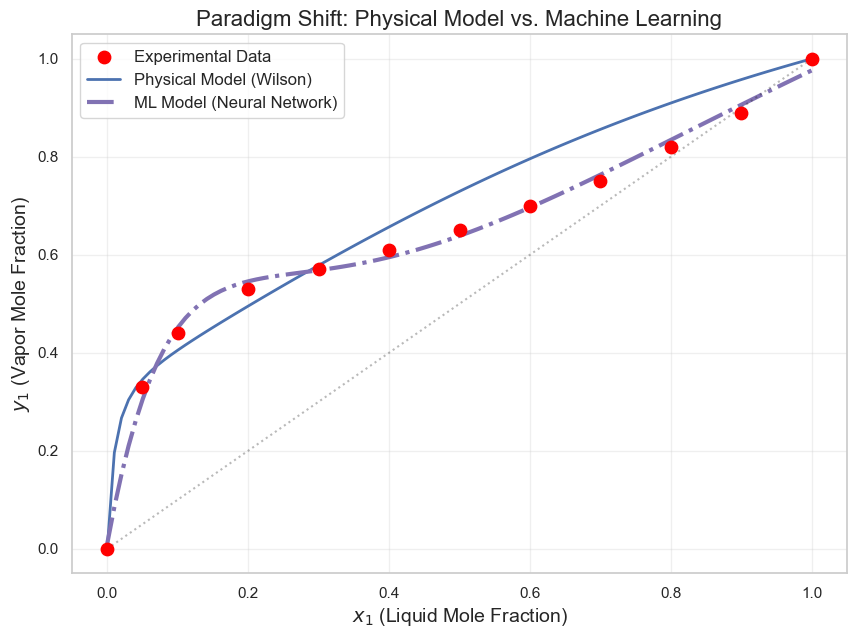

In [52]:
from sklearn.neural_network import MLPRegressor

# 1. 數據準備 (Scikit-learn 要求輸入為 2D 陣列)
X_train = x1_exp.reshape(-1, 1)
y_train = y1_exp

# 2. 建立 ANN 模型
# hidden_layer_sizes=(10, 10): 兩個隱藏層，每層 10 個神經元，這對於簡單曲線已足夠
# activation='tanh': 雙曲正切函數，適合擬合平滑、非線性的物理曲線
# solver='lbfgs': 準牛頓法優化器，對於小數據集 (N < 1000) 收斂效果比 Adam 更好
ann_model = MLPRegressor(hidden_layer_sizes=(10, 10), 
                         activation='tanh', 
                         solver='lbfgs', 
                         max_iter=5000, 
                         random_state=42)

# 3. 訓練模型
ann_model.fit(X_train, y_train)

# 4. 預測與評估
y_pred_ann = ann_model.predict(X_train)
rmse_ann = np.sqrt(mean_squared_error(y_train, y_pred_ann))

print(f"Wilson Model RMSE: {rmse_wilson:.5f}")
print(f"ANN Model RMSE:    {rmse_ann:.5f}")

# 5. 視覺化比較
x_smooth_2d = x_smooth.reshape(-1, 1)
y_smooth_ann = ann_model.predict(x_smooth_2d)

plt.figure(figsize=(10, 7))
plt.scatter(x1_exp, y1_exp, color='red', s=80, label='Experimental Data', zorder=5)

# 繪製 Wilson 曲線 (物理模型)
plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, label='Physical Model (Wilson)')

# 繪製 ANN 曲線 (黑盒模型)
plt.plot(x_smooth, y_smooth_ann, 'm-.', linewidth=3, label='ML Model (Neural Network)')

plt.plot([0, 1], [0, 1], 'k:', alpha=0.3)
plt.xlabel(r'$x_1$ (Liquid Mole Fraction)', fontsize=14)
plt.ylabel(r'$y_1$ (Vapor Mole Fraction)', fontsize=14)
plt.title('Paradigm Shift: Physical Model vs. Machine Learning', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / 'B08_ai_vs_physics.png')
plt.show()

### 詳細結果分析與討論 (Detailed Analysis & Discussion)

透過上圖與 RMSE 數值的比較，我們可以深入探討兩種建模典範的差異：

#### 1. 擬合精度 (Accuracy vs. Overfitting)
- **觀察**：在訓練數據點（紅點）上，ANN 模型（洋紅線）通常能達到比 Wilson 模型（藍線）更低的 RMSE。
- **原因**：Wilson 模型受到物理方程式形式的限制（只有兩個參數 $A_{12}, A_{21}$），它只能產生特定形狀的曲線。而 ANN 擁有數十個權重參數 (Weights)，具有更高的自由度來「記憶」數據點的位置。
- **風險**：若數據點含有實驗誤差（雜訊），ANN 可能會為了遷就雜訊而產生不自然的扭曲（過擬合），而物理模型則具有自然的平滑濾波效果。

#### 2. 曲線平滑度與物理意義 (Smoothness & Physics)
- **Wilson 模型**：保證了曲線的單調性與平滑性，且隱含滿足 **Gibbs-Duhem 方程式**（熱力學一致性）。這意味著它預測的性質在物理上是合理的。
- **ANN 模型**：雖然使用 `tanh` 激活函數能產生平滑曲線，但它並不懂熱力學。
    - **邊界問題**：請觀察 $x_1$ 接近 0 或 1 的區域。ANN 是否預測出 $y_1 < 0$ 或 $y_1 > 1$ 的不合理數值？
    - **共沸點**：ANN 純粹透過數據插值找到 $y=x$ 的交點，而 Wilson 模型則是透過活度係數的物理定義推導出來的。

#### 3. 外推能力 (Extrapolation)
- 這是 AI 模型在科學應用上最大的弱點。
- 若我們嘗試預測 $x_1 = 1.2$ (物理上不可能) 或溫度改變時的 VLE：
    - **Wilson 模型**：仍能依據方程式給出數學上可計算的值，且若結合溫度相依性公式，可合理推估不同溫度下的行為。
    - **ANN 模型**：在訓練範圍 $[0, 1]$ 之外，其預測行為是不可控的（可能趨向常數或發散至無限大），完全不具備外推能力。

#### 結論 (Conclusion)
在化工製程模擬中，若系統機制明確（如本例），**物理模型 (First-Principles)** 仍是首選。但在物理機制未明（如複雜反應動力學、多成份膜分離）或計算成本過高（如 CFD 替代模型）時，**資料驅動 (Data-Driven)** 的 AI 模型則是極具潛力的工具。